# Enunciado

Realizar el ejercicio 2 de Naive Bayes y KNN con árboles de decisión.

# 1. Importación de los datos

In [2]:
import pandas as pd
df = pd.read_csv('csv/data2.csv')
df['Label'] = df['Label'].astype('int')
df

,Feature_1,Feature_2,Label
0,0.496714,0.000000,0
1,0.647689,1.523030,0
2,0.000000,0.000000,0
3,1.579213,0.767435,0
4,0.000000,0.542560,0
...,...,...,...
995,3.800410,3.754291,1
996,4.188913,3.708304,1
997,3.351448,4.070150,1
998,2.973479,2.118125,1


# 2. Preparación de los datos

In [3]:
# Separar los datos de entrada y salida
X = df.drop('Label', axis=1)
y = df['Label']

# 3. Visualización de los datos

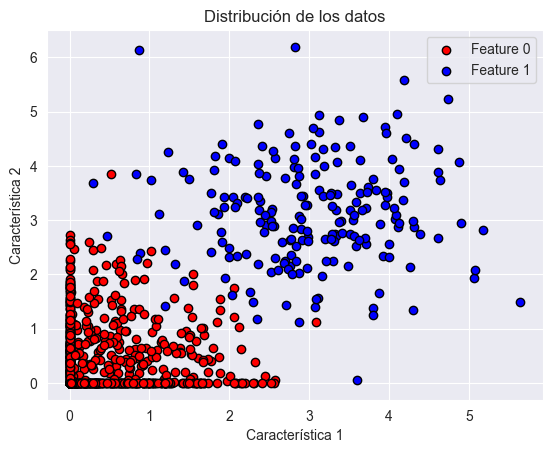

In [4]:
from matplotlib import pyplot as plt

COLORS = ['red', 'blue']

for i, data in enumerate(df.groupby('Label').apply(lambda x: x[['Feature_1', 'Feature_2']].values)):
    plt.scatter(data[:, 0], data[:, 1], c=COLORS[i], edgecolors='k', label=f'Feature {i}')
    
plt.title('Distribución de los datos')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')
plt.legend()
plt.show()

# 4. Visualización de la distribución de los datos

Label
0    800
1    200
Name: Label, dtype: int64


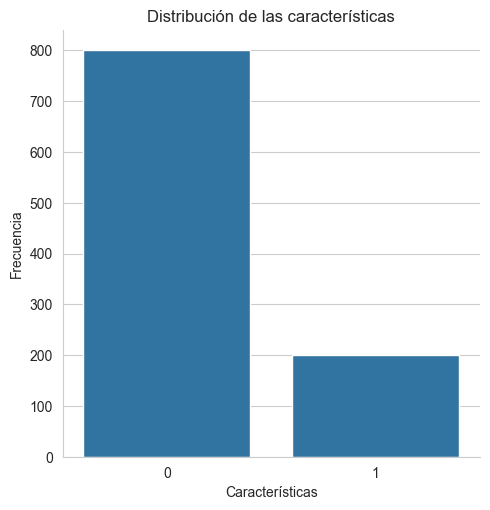

In [5]:
import seaborn as sns

sns.set_style('whitegrid')
print(df['Label'].groupby(df['Label']).size())
sns.catplot(x='Label', kind='count', data=df)
plt.title('Distribución de las características')
plt.xlabel('Características')
plt.ylabel('Frecuencia')
plt.show()

# 5. Preparación del conjunto de datos

In [6]:
from sklearn.model_selection import train_test_split

p_train = 0.7

train, test = train_test_split(df, train_size=p_train, random_state=42)

# inplace=True: Modifica el dataframe original en lugar de devolver uno nuevo
train.reset_index(inplace=True)
test.reset_index(inplace=True)

print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

print("Conjunto de entrenamiento:")
print(train.head())

print("Conjunto de prueba:")
print(test.head())

Train: (700, 4)
Test: (300, 4)
Conjunto de entrenamiento:
   index  Feature_1  Feature_2  Label
0    541   0.000000   2.076748      0
1    440   2.526932   0.000000      0
2    482   0.000000   1.440117      0
3    422   0.166452   0.492451      0
4    778   0.913585   0.000000      0
Conjunto de prueba:
   index  Feature_1  Feature_2  Label
0    521   1.078681   0.000000      0
1    737   0.000000   0.648280      0
2    740   0.722381   0.000000      0
3    660   0.056650   0.529693      0
4    411   2.298898   0.000000      0


# 6. Validación cruzada

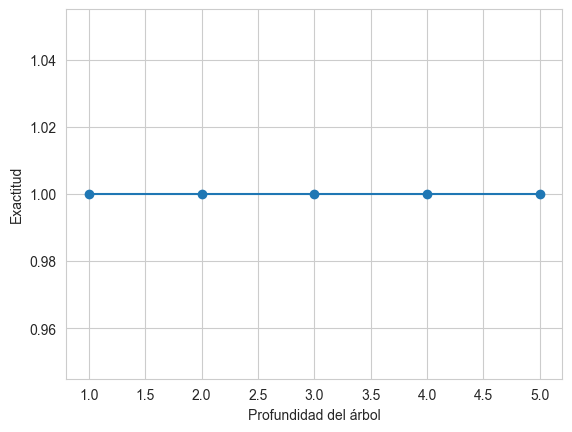

In [7]:
from sklearn import tree
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

cv = KFold(n_splits=5, shuffle=False)
accuracies = list()
max_attributes = len(list(df))
depth_range = range(1, max_attributes * 2)

# Testeamos la profundidad de los árboles
for depth in depth_range:
    fold_accuracy = []  # Reiniciamos la lista para cada profundidad
    tree_model = tree.DecisionTreeClassifier(
        criterion='entropy',
        max_depth=depth
    )
    for train_fold, test_fold in cv.split(train):
        f_train = train.loc[train_fold] 
        f_test = train.loc[test_fold] 

        model = tree_model.fit(X=f_train.drop(['Label'], axis=1),
                               y=f_train['Label'])
        
        test_acc = model.score(X=f_test.drop(['Label'], axis=1),
                               y=f_test['Label'])
        
        fold_accuracy.append(test_acc)
    
    accuracies.append(np.mean(fold_accuracy))

# Mostramos los resultados
plt.plot(depth_range, accuracies, marker='o')
plt.xlabel('Profundidad del árbol')
plt.ylabel('Exactitud')
plt.show()

# Obtenemos la mejor profundidad
best_depth = depth_range[np.argmax(accuracies)]

# 7. Creación del modelo

In [8]:
from sklearn.metrics import classification_report

X_train = train[['Feature_1', 'Feature_2']]
y_train = train['Label']
X_test = test[['Feature_1', 'Feature_2']]
y_test = test['Label']

model = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=best_depth
)

model = model.fit(X=X_train, y=y_train)

y_pred = model.predict(X_test)

print(classification_report(test['Label'], y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       236
           1       0.87      0.91      0.89        64

    accuracy                           0.95       300
   macro avg       0.92      0.93      0.93       300
weighted avg       0.95      0.95      0.95       300


# 8. Visualización del modelo

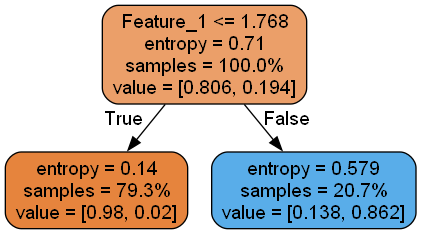

In [9]:
import pydot
from IPython.display import Image
from sklearn import tree
from io import StringIO

dot_data = StringIO()
tree.export_graphviz(
    model, 
    out_file=dot_data, 
    proportion=True,
    feature_names=X_train.columns,
    rounded=True,
    filled=True
)

graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())

## Matriz de confusión

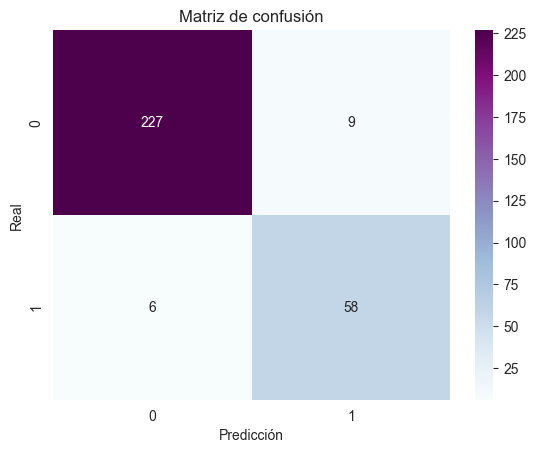

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(test['Label'], y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu')
plt.title('Matriz de confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()